In [5]:
import sys
sys.path.append("/home/debian/gabe/SO_Post_Analyzer")

In [6]:
import csv
import datetime
import tqdm
import random
import nltk
import numpy as np
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

from follow_up_projects.urn_model.polyas_urn_model import urn_simulation


In [7]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def get_wordnet_pos(treebank_tag):
    """Map NLTK POS tags to WordNet POS tags."""
    if treebank_tag.startswith('N'):
        return wordnet.NOUN
    return None


def extract_singular_nouns(text):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    
    lemmatizer = WordNetLemmatizer()
    
    singular_nouns = []
    for word, tag in tagged:
        wn_tag = get_wordnet_pos(tag)
        if wn_tag == wordnet.NOUN:
            singular_form = lemmatizer.lemmatize(word, pos=wn_tag)
            singular_nouns.append(singular_form)
    
    return singular_nouns

[nltk_data] Downloading package punkt to /home/debian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/debian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/debian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
titles = []
nouns = []
with open("data/BooksDatasetClean.csv") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in tqdm.tqdm(reader):
        published = datetime.datetime.strptime(
            f"{row['Publish Date (Year)']},{row['Publish Date (Month)']},1",
            "%Y,%B,%d").date()
        # initial filter&format
        lower_alphas = [w.lower().strip() for w in row['Title'].split() if w.isalpha()]
        extracted_nouns = extract_singular_nouns(" ".join(lower_alphas))
        assert len(extracted_nouns) <= len(lower_alphas)
        
        titles.append((published, lower_alphas))
        nouns.append((published, extracted_nouns))


103063it [00:44, 2321.44it/s]


In [10]:
sorted_nouns = sorted(nouns)
sorted_titles = sorted(titles)

In [11]:
import itertools
import matplotlib.pyplot as plt

word_have_seen = set()
word_counts = []

word_pair_have_seen = set()
word_pair_counts = []

noun_have_seen = set()
noun_counts = []

noun_pair_have_seen = set()
noun_pair_counts = []

for dt, words in sorted_titles:
    for word in words:
        word_have_seen.add(word)
    word_counts.append(len(word_have_seen))
    for combos in itertools.combinations(words, 2):
        canonical_name = "|".join(sorted(combos))
        word_pair_have_seen.add(canonical_name)
    word_pair_counts.append(len(word_pair_have_seen))

for dt, nouns in sorted_nouns:
    for noun in nouns:
        noun_have_seen.add(noun)
    noun_counts.append(len(noun_have_seen))
    for combos in itertools.combinations(nouns, 2):
        canonical_name = "|".join(sorted(combos))
        noun_pair_have_seen.add(canonical_name)
    noun_pair_counts.append(len(noun_pair_have_seen))

Text(0.5, 1.0, 'Unique Words in Book Titles')

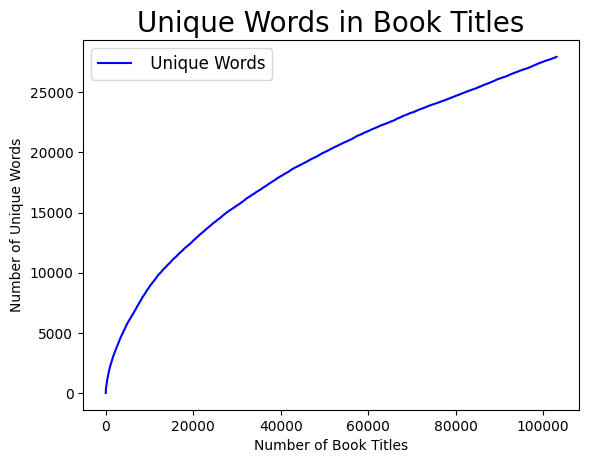

In [12]:
plt.plot(range(len(word_counts)), word_counts, "b-", label=" Unique Words")
#plt.plot(range(len(word_pair_counts)), word_pair_counts, "b--", label=" Unique Word Pairs")
#plt.plot(range(len(noun_counts)), noun_counts, "r-", label=" Unique Nouns")
#plt.plot(range(len(noun_pair_counts)), noun_pair_counts, "r--", label=" Unique Noun Pairs")

plt.xlabel("Number of Book Titles")
plt.ylabel("Number of Unique Words")
plt.legend(fontsize=12)
plt.title("Unique Words in Book Titles", fontsize=20)
#plt.loglog()

In [13]:
print((noun_counts[-1] - noun_counts[-60_001]) /60_000)
print((word_counts[-1] - word_counts[-60_001]) / 60_000)

0.1039
0.154


In [43]:
from sklearn.linear_model import LinearRegression

xs = np.array(range(1, len(word_counts)+1))
xs_transformed = np.log(xs).reshape(-1 ,1 )
counts_transformed = np.log(np.array(word_counts) + 1)

model = LinearRegression()
model.fit(xs_transformed, counts_transformed)

alpha = model.coef_[0]
log_c = model.intercept_
c = np.exp(log_c)


# Do the same fit for pairs
pairs_xs = np.array(range(1, len(word_pair_counts)+1))
pairs_xs_transformed = np.log(pairs_xs).reshape(-1 ,1 )
pairs_counts_transformed = np.log(np.array(word_pair_counts) + 1)

model = LinearRegression()
model.fit(pairs_xs_transformed, pairs_counts_transformed)

pairs_alpha = model.coef_[0]
pairs_log_c = model.intercept_
pairs_c = np.exp(pairs_log_c)



In [15]:
sorted_titles_lengths = [len(title[1]) for title in sorted_titles]

In [16]:
bps = 400
nei = 50
noi = 800
sim = urn_simulation(rounds=len(titles), base_pool_size=bps, new_element_increment=nei, new_opportunity_increment=noi, card_sizes=sorted_titles_lengths) 

100%|█████████████████████████████████████████████████████████████████████| 103063/103063 [00:06<00:00, 16426.57it/s]


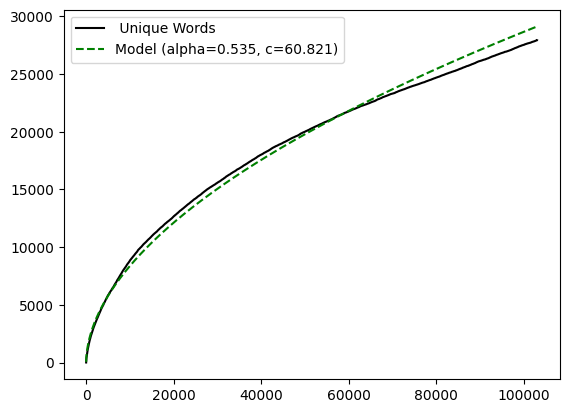

In [48]:
plt.plot(xs, word_counts, "k-", label=" Unique Words")
#plt.plot(xs, word_pair_counts, "k-", label=" Unique Word Pairs")

plt.plot(xs, [c * x ** alpha for x  in xs], "--", color='green', label=f"Model (alpha={round(alpha, 3)}, c={round(c, 3)})")
#plt.plot(xs, sim["element_counts"], "--", color='red', label=f"Sim (bps: {bps} nei: {nei} noi: {noi})")
#plt.plot(xs, sim["pairs_counts"], "k--",label=f"Sim (bps: {bps} nei: {nei} noi: {noi})")
#plt.plot(xs, word_pair_counts, "r-", label="Unique Pairs")
#plt.plot(xs, [pairs_c * x ** pairs_alpha for x  in xs], "--",
#         color='black', label=f"Pairs Model (alpha={round(pairs_alpha, 3)}, c={round(pairs_c, 3)})")


plt.legend()

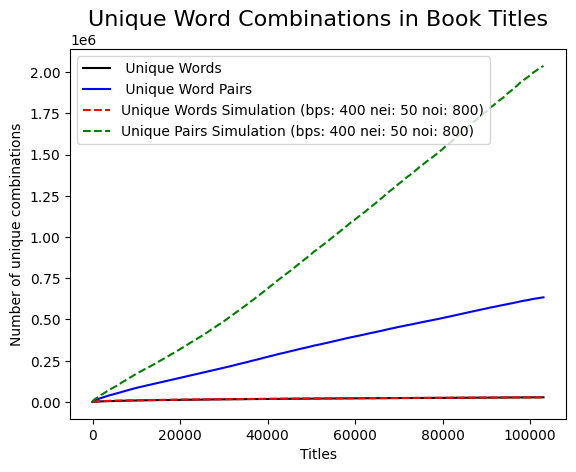

In [51]:
plt.plot(xs, word_counts, "k-", label=" Unique Words")
plt.plot(xs, word_pair_counts, "b-", label=" Unique Word Pairs")

#plt.plot(xs, [c * x ** alpha for x  in xs], label=f"Model (alpha={round(alpha, 3)}, c={round(c, 3)})")
plt.plot(xs, sim["element_counts"], "--", color="red", label=f"Unique Words Simulation (bps: {bps} nei: {nei} noi: {noi})")
plt.plot(xs, sim["pairs_counts"], "--", color="green", label=f"Unique Pairs Simulation (bps: {bps} nei: {nei} noi: {noi})")
plt.title("Unique Word Combinations in Book Titles", fontsize=16)
plt.xlabel("Titles")
plt.ylabel("Number of unique combinations")
plt.legend()
#plt.loglog()